# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [53]:
# Load pickled data
import pickle

# TODO: fill this in based on where you saved the training and testing data
training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

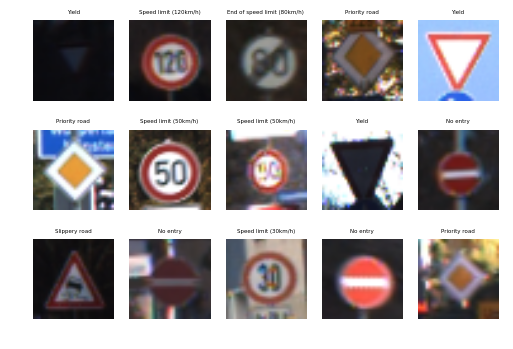

In [54]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

import matplotlib.pyplot as plt
from random import randint
import numpy as np
import math
import csv
%matplotlib inline

number_of_test_images_to_show = 15
indexes_of_test_images_to_show = np.random.choice(len(X_train), number_of_test_images_to_show)

label_to_title = []

def read_signnames(filename):
    with open(filename, 'rt', encoding='utf8') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
        return [row[1] for row in spamreader if row[0] != 'ClassId']

def show_images(images, labels, indexes_of_images_to_show, cmap = None):
    assert len(images) == len(labels)
    
    images_per_row = 5
    images_per_colon = math.ceil(len(indexes_of_images_to_show) / images_per_row)
    cur_image = 1
    
    fig = plt.figure()
    
    for index in indexes_of_images_to_show:
        image = images[index]
        label = labels[index]
        
        subplot = fig.add_subplot(images_per_colon, images_per_row, cur_image)
        plt.axis('off')
        plt.imshow(image, cmap = cmap)
        subplot.set_title(label_to_title[label], fontsize=4)
        
        cur_image += 1

label_to_title = read_signnames('signnames.csv') 
show_images(X_train, y_train, indexes_of_test_images_to_show)

In [55]:
### To start off let's do a basic data summary.

from itertools import groupby

# TODO: number of training examples
n_train = len(X_train)

# TODO: number of testing examples
n_test = len(X_test)

# TODO: what's the shape of an image?
image_shape = X_test[0].shape

# TODO: how many classes are in the dataset
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

for key, group in groupby(y_train):
    print("Class:", key, "\tName:", label_to_title[key], "\tCount:", len(list(group)), )

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43
Class: 0 	Name: Speed limit (20km/h) 	Count: 210
Class: 1 	Name: Speed limit (30km/h) 	Count: 2220
Class: 2 	Name: Speed limit (50km/h) 	Count: 2250
Class: 3 	Name: Speed limit (60km/h) 	Count: 1410
Class: 4 	Name: Speed limit (70km/h) 	Count: 1980
Class: 5 	Name: Speed limit (80km/h) 	Count: 1860
Class: 6 	Name: End of speed limit (80km/h) 	Count: 420
Class: 7 	Name: Speed limit (100km/h) 	Count: 1440
Class: 8 	Name: Speed limit (120km/h) 	Count: 1410
Class: 9 	Name: No passing 	Count: 1470
Class: 10 	Name: No passing for vechiles over 3.5 metric tons 	Count: 2010
Class: 11 	Name: Right-of-way at the next intersection 	Count: 1320
Class: 12 	Name: Priority road 	Count: 2100
Class: 13 	Name: Yield 	Count: 2160
Class: 14 	Name: Stop 	Count: 780
Class: 15 	Name: No vechiles 	Count: 630
Class: 16 	Name: Vechiles over 3.5 metric tons prohibited 	Count: 420
Class: 17 

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

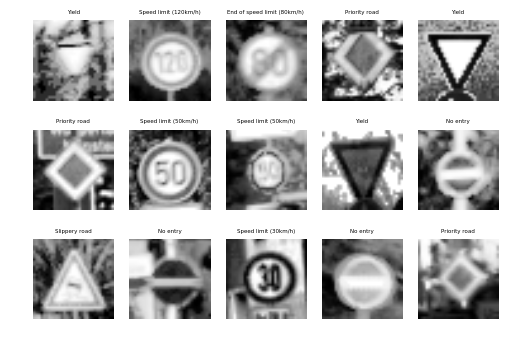

In [56]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

import cv2
from sklearn.preprocessing import LabelBinarizer

def normalize_image(image):
    a = -0.9
    b = 0.9
    x_min = 0.
    x_max = 255.
    return a + ((image-x_min) * (b - a)) / (x_max - x_min)

def normailize_images(images):
    return [normalize_image(image) for image in images]

def preprocess_image(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    eq_image = cv2.equalizeHist(gray_image)
    return eq_image;

def preprocess_images(images):
    return [preprocess_image(image) for image in images]

def binarize_labels(labels, classes_count):
    encoder = LabelBinarizer()
    encoder.fit(range(classes_count))
    labels = encoder.transform(labels)
    
    # Change to float32, so it can be multiplied against the features in TensorFlow, which are float32
    labels = labels.astype(np.float32)
    
    return labels

def reshape_images(images, num_channels):
    return [image.reshape([image_shape[0],image_shape[1],num_channels]) for image in images]

y_train_bin = binarize_labels(y_train, n_classes)
y_test_bin = binarize_labels(y_test, n_classes)

X_train_prep = preprocess_images(X_train)
X_test_prep = preprocess_images(X_test)

X_train_norm = normailize_images(X_train_prep)
X_test_norm = normailize_images(X_test_prep)

num_channels = 1

X_train_shaped = reshape_images(X_train_norm, num_channels)
X_test_shaped = reshape_images(X_test_norm, num_channels)

train_permutation = np.random.permutation(len(X_train_shaped))

X_train_shuffled = np.array(X_train_shaped)[train_permutation]
y_train_shuffled = np.array(y_train_bin)[train_permutation]

features_count = len(X_train_shaped[0])
labels_count = n_classes

show_images(X_train_prep, y_train, indexes_of_test_images_to_show, cmap = 'gray')

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**
My neural network seems to perform better with grayscale, so I converted images for that. I further normalized the contrast, which also seems to help with performance. I've also normalized image to be zero centered and range from -0.9 to 0.9, to help neural network converge faster. I've tried HSV, RGB and YUV color schemes with and without normalizations, and they did not deliver better results than grayscale. In this step I've also binarized the labels. Finally, I've shuffled training labels and data, so network doesn't overlearn while getting the same sign in one batch of learning. If I had more time, I would try generating more data for the neural network by altering images through affine transformations. This should help recognize new images, and equalize number of images per class.

In [57]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

from sklearn.model_selection import train_test_split

train_features, valid_features, train_labels, valid_labels = train_test_split(
    X_train_shuffled,
    y_train_shuffled,
    test_size=0.1,
    train_size=0.9,
    random_state=936602)

test_features, test_labels = X_test_shaped, y_test_bin

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**
I have allocated 90% of data for training, and 10% for validation. This ratio seems to provide decent amount of data for validation, while keeping enough data for training. I have generated binarized labels in the previous step. This is done to avoid false sense of continuity in the data - e.g. sign having label 42 isn't in any way related to sign having label 41.

In [59]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

import tensorflow as tf

# Configuration

# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 32         # There are 32 of these filters.

# Fully-connected layer 1.
fc_size1 = 256             # Number of neurons in fully-connected layer.

# Fully-connected layer 2.
fc_size2 = 128             # Number of neurons in fully-connected layer.

# Helper functions from https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/02_Convolutional_Neural_Network.ipynb
def new_weights(shape, has_relu):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape, has_relu=True)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights, biases

def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features

def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs], has_relu=use_relu)
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer, weights, biases


features = tf.placeholder(tf.float32, shape=[None, image_shape[0], image_shape[1], num_channels])
labels = tf.placeholder(tf.float32, shape=[None, labels_count])


layer_conv1, weights_conv1, bias_conv1 = \
    new_conv_layer(input=features,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)
    
layer_conv2, weights_conv2, bias_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)
    
layer_flat, num_features = flatten_layer(layer_conv2)

layer_fc1, weights_fc1, bias_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size1,
                         use_relu=True)

layer_fc2, weights_fc2, bias_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size1,
                         num_outputs=fc_size2,
                         use_relu=True)

layer_fc3, weights_fc3, bias_fc3 = new_fc_layer(input=layer_fc2,
                         num_inputs=fc_size2,
                         num_outputs=labels_count,
                         use_relu=False)

prediction = tf.nn.softmax(layer_fc3)

# Cross entropy
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc3,
                                                        labels=labels)

# Training loss
loss = tf.reduce_mean(cross_entropy)

prediction_argmax = tf.argmax(prediction, 1)
labels_argmax = tf.argmax(labels, 1)

# Determine if the predictions are correct
is_correct_prediction = tf.equal(prediction_argmax, labels_argmax)

# Calculate the accuracy of the predictions
accuracy = tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32))

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**
This neural network has 2 serial convolution layers, outputting to 3 serial fully connected layers. Convolution layers have filter size of 5, with number of filters being 16 32 respectively. Each convolution layer uses max pooling. Fully connected layers have output sizes 256 128 43 respectively. Between all fully connected and convolution layers there is a ReLU layer. I've tried using bigger networks - 3 convolution and 4 fully connected layers with weights and biases reguralization, but it was not performing as good. I've also tried Xavier initialization, which slowed down the learning and did not improve performance. Disclosure: I've used helper functions found here: https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/02_Convolutional_Neural_Network.ipynb

In [61]:
### Train your model here.
### Feel free to use as many code cells as needed.

import matplotlib.pyplot as plt

def plot_training_log(batches, train_loss_batch, valid_loss_batch, train_acc_batch, valid_acc_batch):
    loss_plot = plt.subplot(211)
    loss_plot.set_title('Loss')
    loss_plot.plot(batches, train_loss_batch, 'r', label='Training Loss')
    loss_plot.plot(batches, valid_loss_batch, 'b', label='Validation Loss')
    loss_plot.set_xlim([batches[0], batches[-1]])
    loss_plot.legend(loc=4)
    acc_plot = plt.subplot(212)
    acc_plot.set_title('Accuracy')
    acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
    acc_plot.plot(batches, valid_acc_batch, 'b', label='Validation Accuracy')
    acc_plot.set_ylim([0, 1.0])
    acc_plot.set_xlim([batches[0], batches[-1]])
    acc_plot.legend(loc=4)
    plt.tight_layout()
    plt.show()

# Feed dicts for training, validation, and test session
train_feed_dict = {features: train_features, labels: train_labels}
valid_feed_dict = {features: valid_features, labels: valid_labels}
test_feed_dict = {features: test_features, labels: test_labels}

epochs = 10
batch_size = 64
learning_rate = 0.001
logging_sample_size = 256

# Gradient Descent
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

# Create an operation that initializes all variables
init = tf.initialize_all_variables()

# The accuracy measured against the validation set
validation_accuracy = 0.0

# Measurements use for graphing loss and accuracy
desired_output_points = 25
log_batch_step = math.ceil(len(train_features)*epochs/batch_size/desired_output_points)
batches = []
train_loss_batch = []
valid_loss_batch = []
train_acc_batch = []
valid_acc_batch = []

session = tf.Session()

session.run(init)
batch_count = int(math.ceil(len(train_features)/batch_size))

Epoch  2/10:   0%|          | 1/552 [00:00<01:19,  6.90batches/s]

Train accuracy at 0.87890625
Validation accuracy at 0.8515625


Epoch  3/10:   0%|          | 1/552 [00:00<01:08,  8.00batches/s]

Train accuracy at 0.98046875
Validation accuracy at 0.96875


Epoch  4/10:   0%|          | 1/552 [00:00<01:06,  8.23batches/s]

Train accuracy at 0.99609375
Validation accuracy at 0.97265625


Epoch  5/10:   0%|          | 1/552 [00:00<01:11,  7.72batches/s]

Train accuracy at 0.99609375
Validation accuracy at 0.98828125


Epoch  6/10:   0%|          | 1/552 [00:00<01:06,  8.33batches/s]

Train accuracy at 0.9921875
Validation accuracy at 0.96484375


Epoch  7/10:   0%|          | 1/552 [00:00<01:10,  7.86batches/s]

Train accuracy at 0.98828125
Validation accuracy at 0.953125


Epoch  8/10:   0%|          | 1/552 [00:00<01:08,  8.00batches/s]

Train accuracy at 1.0
Validation accuracy at 0.99609375


Epoch  9/10:   0%|          | 1/552 [00:00<01:12,  7.63batches/s]

Train accuracy at 1.0
Validation accuracy at 0.98046875


Epoch 10/10:   0%|          | 1/552 [00:00<01:05,  8.38batches/s]

Train accuracy at 1.0
Validation accuracy at 0.9765625


Epoch 10/10: 100%|██████████| 552/552 [01:13<00:00,  7.50batches/s]


Train accuracy at 0.9921875
Validation accuracy at 0.9765625


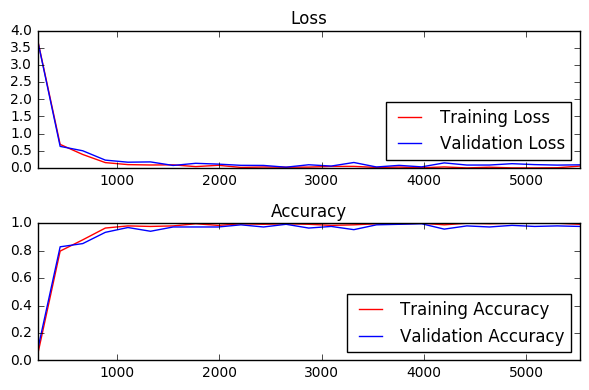

In [62]:
from tqdm import tqdm

for epoch_i in range(epochs):
    # Progress bar
    batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch_i+1, epochs), unit='batches')

    # The training cycle
    for batch_i in batches_pbar:
        # Get a batch of training features and labels
        batch_start = batch_i*batch_size
        batch_features = train_features[batch_start:batch_start + batch_size]
        batch_labels = train_labels[batch_start:batch_start + batch_size]

        # Run optimizer and get loss
        session.run(
            optimizer,
            feed_dict={features: batch_features, labels: batch_labels})

        # Log
        if not (epoch_i * batch_count + batch_i) % log_batch_step:
            # Calculate Training and Validation accuracy (estimate)
            training_indexes = np.random.choice(len(train_features), logging_sample_size)
            training_accuracy, training_loss = session.run([accuracy, loss], feed_dict={features: train_features[training_indexes], labels: train_labels[training_indexes]})
            
            validation_indexes = np.random.choice(len(valid_features), logging_sample_size)
            validation_accuracy, validation_loss = session.run([accuracy, loss], feed_dict={features: valid_features[validation_indexes], labels: valid_labels[validation_indexes]})

            # Log batches
            previous_batch = batches[-1] if batches else 0
            batches.append(log_batch_step + previous_batch)
            train_loss_batch.append(training_loss)
            valid_loss_batch.append(validation_loss)
            train_acc_batch.append(training_accuracy)
            valid_acc_batch.append(validation_accuracy)

    print('Train accuracy at {}'.format(training_accuracy))
    print('Validation accuracy at {}'.format(validation_accuracy))
    
plot_training_log(batches, train_loss_batch, valid_loss_batch, train_acc_batch, valid_acc_batch)

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**
I used Adam optimizer, which seem to provide greater convergence speed, while avoiding being stuck on plateau or overshooting such as Momentum optimizer. I've chosen batch size to be 64, which trains network faster than bigger sizes because of more frequent updates. This size also allowed me to try bigger networks without exceeding RAM available on my machine and resulting trashing. 10 epochs seem to be enough to get decently accurate results, and further training doesn't seem to be beneficial. I've selected 0.001 learning rate, which seem to be faster then 0.0001 but about as good in accuracy. For logging, I've used estimate of loss and accuracy for validation and training sets on a random sample of size 256. Using small sample gave me performance without significant loss in accuracy.

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**
I started with a simple solution from a previous lab. Then I was trying to solve some problems found, such as all weights turning to nan. After that I was watching Stanford lectures such as this one https://www.youtube.com/watch?v=GUtlrDbHhJM&t=3s#t=5.480207704, paper http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf and tutorial https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/02_Convolutional_Neural_Network.ipynb trying to spot some best practices, then employ them and see if they work for me. I was also trying to observe the data through visualizations and printouts to notice some patterns in data, weights, biases or outputs that may provide me some hints on potential improvements.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

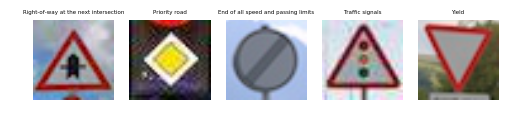

In [63]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

from scipy import misc

custom_images_filenames = ['right_of_way.jpg', 'priority_road.jpg', 'nolimit.jpg', 'traffic_signals.jpg', 'yield.jpg']
custom_images = [misc.imread(filename) for filename in custom_images_filenames]
custom_images_labels = [11, 12, 32, 26, 13]

show_images(custom_images, custom_images_labels, range(len(custom_images)))

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**
The "Traffic signals" sign is easy to confuse with "General caution". Color color can help, but color hurts general accuracy of the neural net. "End of all speed and passing limits" is somewhat similar to "End of speed limit (80 km/h)". Finally, yield sign is somewhat tilted and may not be easily recognizable. 

In [64]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

custom_images_labels_bin = binarize_labels(custom_images_labels, n_classes)
custom_images_prep = preprocess_images(custom_images)
custom_images_norm = normailize_images(custom_images_prep)
custom_images_shaped = reshape_images(custom_images_prep, num_channels)

custom_feed_dict = {features: custom_images_shaped, labels: custom_images_labels_bin}

custom_prediction = session.run(prediction, feed_dict=custom_feed_dict)
custom_prediction_argmax = session.run(prediction_argmax, feed_dict=custom_feed_dict)

custom_accuracy = session.run(accuracy, feed_dict=custom_feed_dict)
test_accuracy = session.run(accuracy, feed_dict=test_feed_dict)

print("Custom images accuracy:", custom_accuracy)
print("Test images accuracy:", test_accuracy)

Custom images accuracy: 0.6
Test images accuracy: 0.918211


### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**
Model had 60% accuracy on a custom images, and 91% accuracy on a test set. In general, depending on neural net parameters, results where lower on custom images then on a test set. "Traffic signals" sign was the hardest to predict, being too similar to "General caution". Yield sign was challenging too, due to it's tilt. Finally, "End of all speed and passing limits" was from time to time confused with another round signs.

    Actual  -> Best guess, by level of confidence


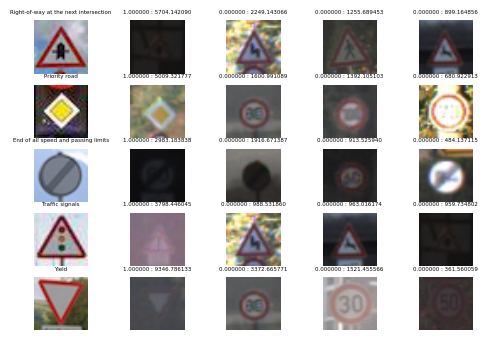

In [72]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

def show_images_with_samples(images, labels, best_guess_labels, best_guess_probability, best_guess_value, library_images, libarary_labels):
    assert len(images) == len(labels)
    assert len(library_images) == len(libarary_labels)
    assert len(labels) == len(best_guess_labels)
    
    images_per_row = len(best_guess_labels[0]) + 1 if len(best_guess_labels) > 0 else 0
    image_count = images_per_row * len(labels)
    images_per_colon = math.ceil(image_count / images_per_row)
    cur_image = 1
    
    fig = plt.figure()
        
    for index, label in enumerate(labels):
        image = images[index]
        
        subplot = fig.add_subplot(images_per_colon, images_per_row, cur_image)
        plt.axis('off')
        plt.imshow(image)
        subplot.set_title(label_to_title[label], fontsize = 4)
        
        cur_image += 1
        
        for guess_index, label in enumerate(best_guess_labels[index]):            
            subplot = fig.add_subplot(images_per_colon, images_per_row, cur_image)
            plt.axis('off')
            title = "%f : %f" % (best_guess_probability[index][guess_index], best_guess_value[index][guess_index])
            subplot.set_title(title, fontsize = 4)
            
            representative_images = np.argwhere(libarary_labels == label)
            if len(representative_images) > 0:
                image_index = representative_images[0]
                library_image = library_images[image_index][0]
                plt.imshow(library_image)
                        
            cur_image += 1

custom_top_k_softmax = tf.nn.top_k(prediction, k=4)
custom_top_k_raw = tf.nn.top_k(layer_fc3, k=4)
custom_top_k_softmax_res, custom_top_k_raw_res = session.run([custom_top_k_softmax, custom_top_k_raw], feed_dict=custom_feed_dict)

print("    Actual  -> Best guess, by level of confidence")
show_images_with_samples(custom_images, custom_images_labels, custom_top_k_raw_res.indices, custom_top_k_softmax_res.values, custom_top_k_raw_res.values, X_train, y_train)

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**
It seems like softmax only gives 1 or 0, which suggests that we have fairly high confidence in prediction, as well as large number of classes. So I used tf.nn.top_k on the fully connected layer result in addition to softmax. "End of all speed and passing limits" came as close second, with a relatively high confidence. However "Traffic signals" sign did not show up in the first 4 best guesses.

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**
I have reshaped images manually. After that I used imread to load the image from file. Then I used the same model and session I had previously for the new images.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.